### **Step 1: Setup and Imports**

This cell installs the `einops` library, which is useful for tensor manipulation, and imports all the necessary libraries.

In [22]:
# Install necessary libraries
!pip install einops

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from einops import rearrange
from tqdm.auto import tqdm
import numpy as np
import math

import matplotlib.pyplot as plt

-----

### **Step 2: Define Model Architecture (U-Net)**

Here, we define the building blocks of the U-Net. This is the core neural network that will learn to predict the noise in the images.

In [23]:
# --- Building Blocks ---

def get_device():
    """
    Checks for a CUDA enabled GPU and returns the appropriate device object.
    If a GPU is not available, returns the CPU device.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sinusoidal time embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Generates sinusoidal position embeddings for time steps.

    Args:
        dim (int): The dimension of the embeddings.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Args:
            time (torch.Tensor): A tensor of time steps.

        Returns:
            torch.Tensor: The sinusoidal position embeddings.
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# U-Net Building Block
class Block(nn.Module):
    """
    A building block for the U-Net model, including convolutional layers,
    batch normalization, ReLU activation, and time embedding integration.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        time_emb_dim (int): Dimension of the time embeddings.
        up (bool): If True, performs upsampling; otherwise, performs downsampling.
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor after applying the block operations.
        """
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


# --- The U-Net Model ---

class SimpleUnet(nn.Module):
    """
    A simplified U-Net implementation for image denoising.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsampling
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsampling
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, 1)

    def forward(self, x, timestep):
        """
        Forward pass of the U-Net model.

        Args:
            x (torch.Tensor): Input image tensor.
            timestep (torch.Tensor): Time step tensor.

        Returns:
            torch.Tensor: Output tensor, predicting the noise.
        """
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

-----

### **Step 3: Define the Diffusion Process (Scheduler)**

This section contains the mathematical heart of DDPM. It defines the noise schedule and the functions for the forward (noising) and reverse (denoising) processes.

In [24]:
# --- Diffusion Scheduler ---

# Define the beta schedule
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Generates a linear beta schedule for the diffusion process.

    Args:
        timesteps (int): The total number of time steps.
        start (float): The starting value of beta.
        end (float): The ending value of beta.

    Returns:
        torch.Tensor: A tensor of beta values.
    """
    return torch.linspace(start, end, timesteps)

# Pre-calculate values for the diffusion process
T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Move tensors to the appropriate device
device = get_device()
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
posterior_variance = posterior_variance.to(device)

# --- Forward Process (q) ---

def q_sample(x_start, t, noise=None):
    """
    Applies noise to an image according to the diffusion process.

    Args:
        x_start (torch.Tensor): The original image tensor.
        t (torch.Tensor): The time step.
        noise (torch.Tensor, optional): The noise to apply. If None, random noise is generated.

    Returns:
        torch.Tensor: The noisy image tensor at time step t.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

    # Reshape to match the image dimensions
    sqrt_alphas_cumprod_t = rearrange(sqrt_alphas_cumprod_t, 'b -> b 1 1 1')
    sqrt_one_minus_alphas_cumprod_t = rearrange(sqrt_one_minus_alphas_cumprod_t, 'b -> b 1 1 1')

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# --- Loss Function ---

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    """
    Calculates the loss between the predicted noise and the actual noise.

    Args:
        denoise_model (nn.Module): The denoising model.
        x_start (torch.Tensor): The original image tensor.
        t (torch.Tensor): The time step.
        noise (torch.Tensor, optional): The actual noise. If None, random noise is generated.
        loss_type (str, optional): The type of loss function to use ('l1', 'l2', or 'huber').

    Returns:
        torch.Tensor: The calculated loss.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

-----

### **Step 4: Load Dataset**

Here we'll load the Fashion-MNIST dataset. It's a good starting point because it's small and trains relatively quickly.

In [25]:
# --- Load Dataset ---

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    """
    Loads and transforms the Fashion-MNIST dataset.

    Returns:
        torch.utils.data.Dataset: The transformed Fashion-MNIST training dataset.
    """
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale data to [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.FashionMNIST(root=".", download=True, train=True, transform=data_transform)
    return train

def show_tensor_image(image):
    """
    Converts a tensor image to a format suitable for displaying with matplotlib.

    Args:
        image (torch.Tensor): The input image tensor.

    Returns:
        np.ndarray: The image as a NumPy array in HWC format, scaled to [0, 255].
    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), # Scale data to [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
    ])

    # Take first image of batch if it's a batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    # Apply the initial transformations
    image_np = reverse_transforms(image).numpy().astype(np.uint8)

    # For grayscale images, squeeze out the channel dimension
    if image_np.shape[-1] == 1:
        image_np = image_np.squeeze(-1)

    return image_np

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Number of samples in the dataset: 60000
Shape of each image: torch.Size([1, 64, 64])
Data type of image tensors: torch.float32

Distribution of labels:
Class 9: 6000 samples
Class 0: 6000 samples
Class 3: 6000 samples
Class 2: 6000 samples
Class 7: 6000 samples
Class 5: 6000 samples
Class 1: 6000 samples
Class 6: 6000 samples
Class 4: 6000 samples
Class 8: 6000 samples

Sample images from each class:


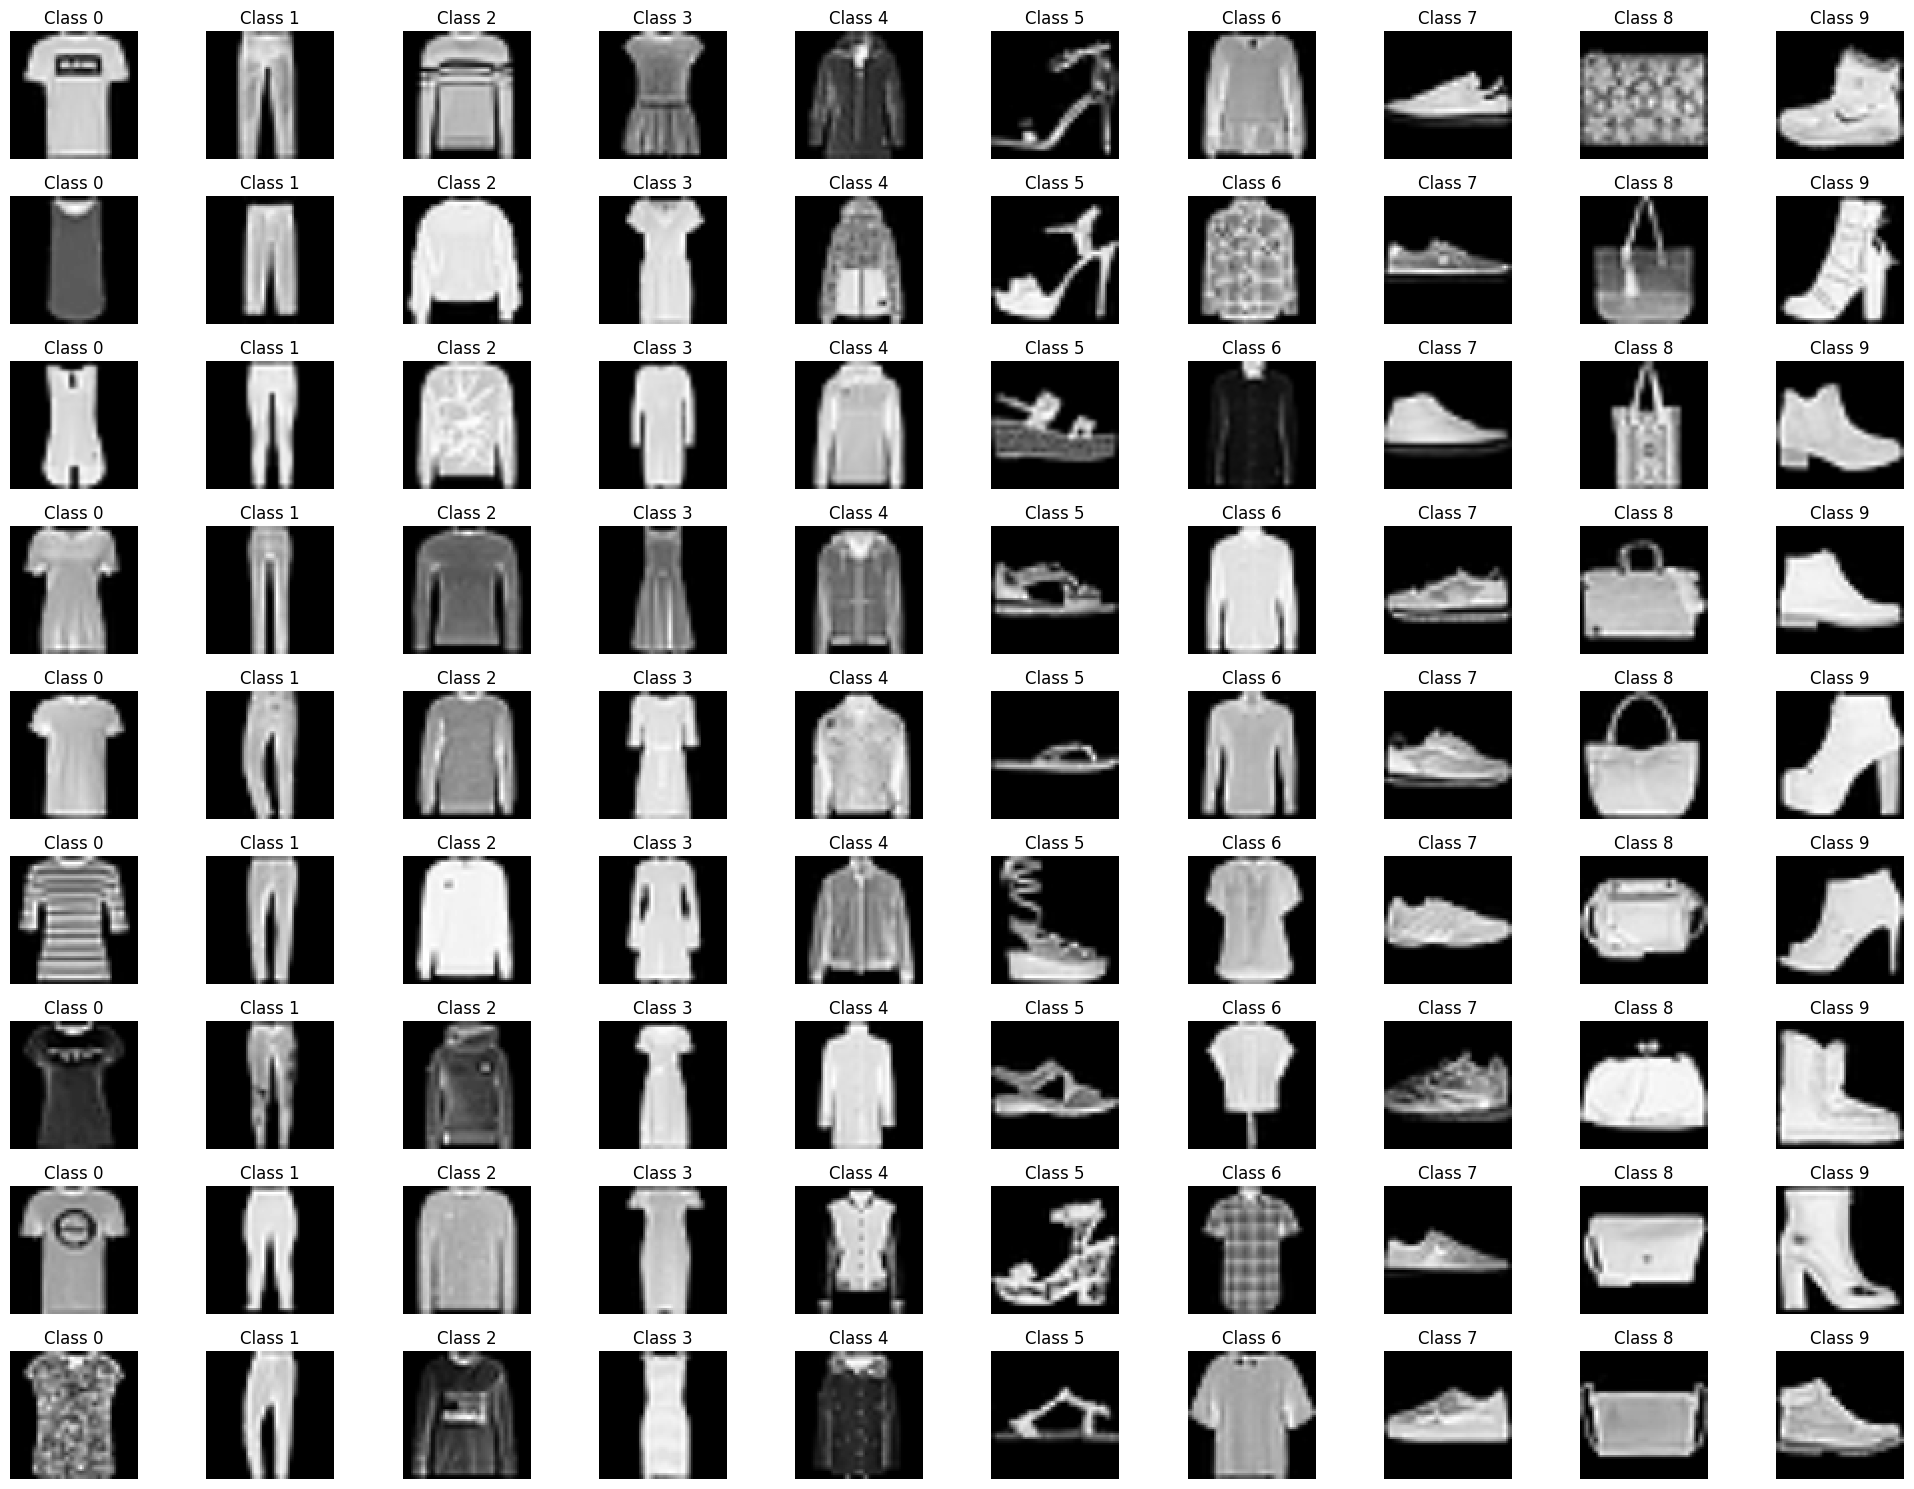

In [26]:
# --- Explore Dataset ---

# Print dataset size
print(f"Number of samples in the dataset: {len(data)}")

# Print image shape
# Access the shape of the first image in the dataset
first_image_shape = data[0][0].shape
print(f"Shape of each image: {first_image_shape}")

# Print data type
first_image_dtype = data[0][0].dtype
print(f"Data type of image tensors: {first_image_dtype}")

# Get the labels (targets) from the dataset
labels = [label for _, label in data]

# Calculate and print label distribution
from collections import Counter
label_counts = Counter(labels)
print("\nDistribution of labels:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

# Display a few example images from each class
print("\nSample images from each class:")

# Define the number of samples to display per class
num_samples_per_class = 9

# Create a dictionary to store multiple images per class
class_images = {label: [] for label in range(10)} # Assuming 10 classes

for image, label in data:
    if len(class_images[label]) < num_samples_per_class: # Collect up to num_samples_per_class images per class
        class_images[label].append(image)
    # Stop if we have collected num_samples_per_class images for all 10 classes
    if all(len(images) == num_samples_per_class for images in class_images.values()):
        break

# Sort the classes for consistent display
sorted_classes = sorted(class_images.keys())

# Create a figure and axes for displaying images
fig, axs = plt.subplots(num_samples_per_class, len(sorted_classes), figsize=(20, 15)) # num_samples_per_class rows

for col_idx, label in enumerate(sorted_classes):
    images_for_class = class_images[label]
    for row_idx, image in enumerate(images_for_class):
        axs[row_idx, col_idx].imshow(show_tensor_image(image), cmap='gray')
        axs[row_idx, col_idx].set_title(f"Class {label}")
        axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

### **About the Fashion-MNIST Dataset**

The Fashion-MNIST dataset is a dataset of 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image, associated with one of 10 fashion item classes. It is intended as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

The 10 classes are:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

-----

### **Step 5: Training**

This is the main training loop. It iterates through the dataset, applies noise, asks the model to predict the noise, and updates the model's weights based on the loss.

In [27]:
# --- Training ---

device = get_device()
model = SimpleUnet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20
# #TODO : remove
# epochs = 1

# List to store loss values for plotting
epoch_losses = []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      batch = batch[0].to(device) # We only need the images, not the labels

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")

      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    # Calculate and store average loss for the epoch
    avg_epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch} finished with average loss: {avg_epoch_loss}")

Epoch 0 | Step 000 | Loss: 0.43686527013778687 
Epoch 0 | Step 100 | Loss: 0.033603303134441376 
Epoch 0 | Step 200 | Loss: 0.02007821574807167 
Epoch 0 | Step 300 | Loss: 0.019580207765102386 
Epoch 0 | Step 400 | Loss: 0.017926137894392014 
Epoch 0 finished with average loss: 0.031218766557196014
Epoch 1 | Step 000 | Loss: 0.019175538793206215 
Epoch 1 | Step 100 | Loss: 0.016296256333589554 
Epoch 1 | Step 200 | Loss: 0.012605502270162106 
Epoch 1 | Step 300 | Loss: 0.014561193995177746 
Epoch 1 | Step 400 | Loss: 0.013891023583710194 
Epoch 1 finished with average loss: 0.015473495607670302
Epoch 2 | Step 000 | Loss: 0.014275817200541496 
Epoch 2 | Step 100 | Loss: 0.012672696262598038 
Epoch 2 | Step 200 | Loss: 0.01306021399796009 
Epoch 2 | Step 300 | Loss: 0.011022830381989479 
Epoch 2 | Step 400 | Loss: 0.01380695030093193 
Epoch 2 finished with average loss: 0.012719784610562472
Epoch 3 | Step 000 | Loss: 0.010082749649882317 
Epoch 3 | Step 100 | Loss: 0.011952109634876251 


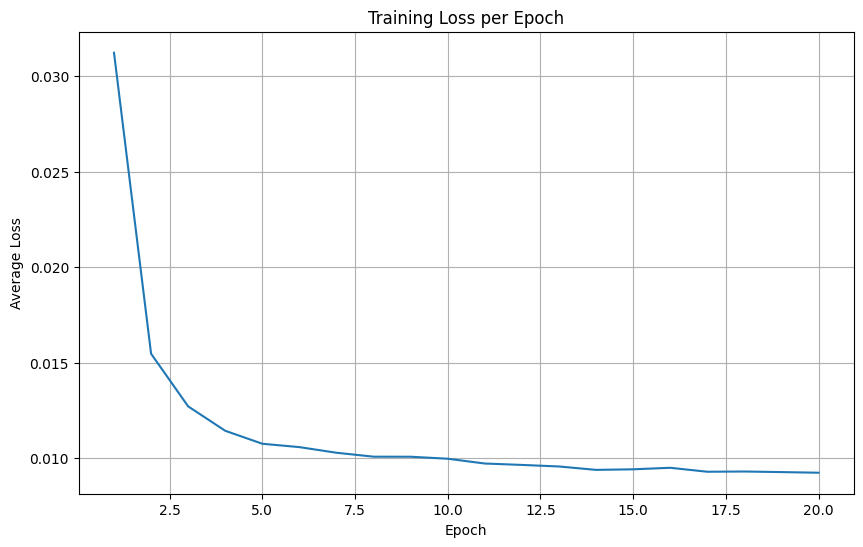

In [28]:
# --- Visualize Training Loss ---

import matplotlib.pyplot as plt

# Check if epoch_losses list exists and has data
if 'epoch_losses' in locals() and len(epoch_losses) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss per Epoch")
    plt.grid(True)
    plt.show()
else:
    print("No epoch_losses data available to plot. Please run the training cell first.")

-----

### **Step 6: Sampling (Image Generation)**

After the model is trained, this is how you generate new images. You start with pure noise and iteratively apply the model to denoise it step-by-step.

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

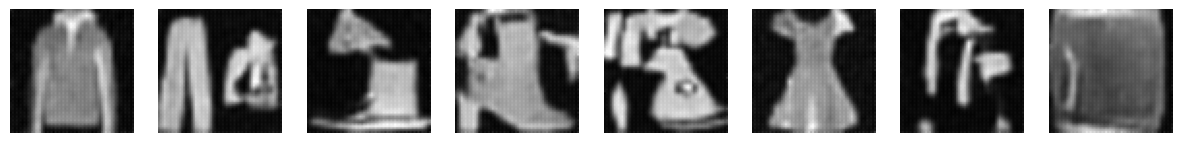

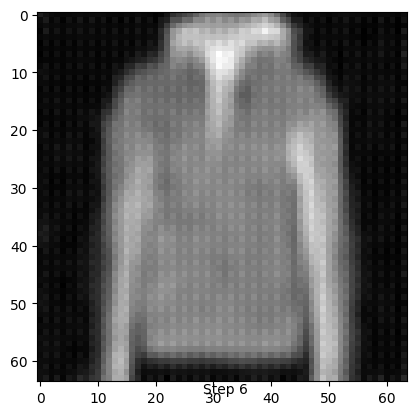

In [29]:
# --- Sampling ---

@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    Performs one step of the reverse diffusion process (denoising).

    Args:
        model (nn.Module): The denoising model.
        x (torch.Tensor): The noisy image tensor at time step t.
        t (torch.Tensor): The current time step.
        t_index (int): The integer index of the current time step (used for accessing pre-calculated values).

    Returns:
        torch.Tensor: The denoised image tensor at time step t-1.
    """
    # Use t for indexing instead of t_index
    betas_t = betas[t]
    betas_t = rearrange(betas_t, 'b -> b 1 1 1')

    # Use t for indexing instead of t_index
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = rearrange(sqrt_one_minus_alphas_cumprod_t, 'b -> b 1 1 1')

    # Use t for indexing instead of t_index
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]
    sqrt_recip_alphas_t = rearrange(sqrt_recip_alphas_t, 'b -> b 1 1 1')

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        # Use t for indexing instead of t_index
        posterior_variance_t = posterior_variance[t]
        posterior_variance_t = rearrange(posterior_variance_t, 'b -> b 1 1 1')
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Performs the full reverse diffusion process to generate images from noise.

    Args:
        model (nn.Module): The trained denoising model.
        shape (tuple): The shape of the output images (batch_size, channels, height, width).

    Returns:
        list: A list of tensors representing the image at each step of the denoising process.
    """
    device = next(model.parameters()).device
    b = shape[0]
    # start from pure noise (for each image in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t, i)
        # store the image at every 50th step
        if i % 50 == 0 or i == T - 1 or i == 0:
             imgs.append(img.cpu())
    return imgs

# --- Generate and Display Images ---

# Generate 8 new images
num_images = 8
generated_images_steps = p_sample_loop(model, shape=(num_images, 1, IMG_SIZE, IMG_SIZE))

# Plot the final generated images
final_images = generated_images_steps[-1]
fig, axs = plt.subplots(1, num_images, figsize=(15, 4))
for i in range(num_images):
    axs[i].imshow(final_images[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

# Optional: Show the full denoising process for one image
import matplotlib.animation as animation
from IPython.display import HTML

# Take the first image from the batch
if generated_images_steps: # Check if the list is not empty
    denoising_process = [step[0].squeeze() for step in generated_images_steps]

    fig = plt.figure()
    ims = []
    for i, img_tensor in enumerate(denoising_process):
        # Calculate the corresponding time step index for the title
        # The images are stored from the last step down to 0.
        # We stored images at i % 50 == 0 or i == T-1 or i == 0
        # Let's find the original time step 't' for each stored image
        # This requires knowing which time steps were stored.
        # A simpler approach for visualization is to just show the index in the stored list or a simplified step count.
        # Let's show the index in the stored list for simplicity in the animation title.
        im = plt.imshow(img_tensor, cmap="gray", animated=True)
        # Add title with the step number in the animation sequence
        title = plt.text(img_tensor.shape[1]//2, img_tensor.shape[0]+2, f"Step {i}",
                         horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')
        ims.append([im, title])

    animate = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000) # Increased interval for better visibility
    # Display the animation
    display(HTML(animate.to_jshtml()))
else:
    print("No generated images steps available for animation.")

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://medium.com/@amir.behbahanian/a-diffusion-model-from-scratch-cf1131988e78">https://medium.com/@amir.behbahanian/a-diffusion-model-from-scratch-cf1131988e78</a></li>
  <li><a href="https://blog.csdn.net/starzhou/article/details/136647213">https://blog.csdn.net/starzhou/article/details/136647213</a></li>
  <li><a href="http://lixudong.ink/author/admin/feed/">http://lixudong.ink/author/admin/feed/</a></li>
  <li><a href="https://whatdhack.medium.com/diffusion-models-for-generative-ai-194c5f877972">https://whatdhack.medium.com/diffusion-models-for-generative-ai-194c5f877972</a></li>
  </ol>
</div>